<a href="https://colab.research.google.com/github/KevinHern/SP2-SFD/blob/master/SignatureForgeryDetection/AI-Research/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Inspiration taken from:
# https://github.com/KevinHern/SP2-SFD/blob/master/SignatureForgeryDetection/Papers/SigNet-Conv-Siamese-Network-for-Writer-Independent-Offline-Signature-Verification.pdf
''' Credit to:
Sounak Deya,∗∗, Anjan Duttaa, J. Ignacio Toledoa, Suman K.Ghosha, Josep Llados´a, Umapada Palb
Computer Vision Center, Computer Science Dept., Universitat Aut`onoma de Barcelona, Edifici O, Campus UAB, 08193 Bellaterra, Spain
Computer Vision and Pattern Recognition Unit, Indian Statistical Institute, 203, B. T. Road, Kolkata-700108, India
'''

' Credit to:\nSounak Deya,∗∗, Anjan Duttaa, J. Ignacio Toledoa, Suman K.Ghosha, Josep Llados´a, Umapada Palb\nComputer Vision Center, Computer Science Dept., Universitat Aut`onoma de Barcelona, Edifici O, Campus UAB, 08193 Bellaterra, Spain\nComputer Vision and Pattern Recognition Unit, Indian Statistical Institute, 203, B. T. Road, Kolkata-700108, India\n'

# Imports


In [2]:
%load_ext tensorboard

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input, Lambda, Subtract, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend as K
import getpass as gp
import sys
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import permutations, combinations
from datetime import date

# To reproduce same results, we seet randomness to 1999
np.random.seed(1999)

# Dataset Processing

## Helping Functions Definition

In [3]:
# Multriprocessing. There are A TON of IMAGES TO LOAD
from multiprocessing import Process, Lock, Manager

routeOriginal = '/content/drive/My Drive/signatures/full_org/'
routeForged = '/content/drive/My Drive/signatures/full_forg/'
routeOriginalProcessed = '/content/drive/My Drive/signatures/full_org_proc/'
routeForgedProcessed = '/content/drive/My Drive/signatures/full_forg_proc/'

# Parallelizable Function
def load_n_process_image(image_path):
    # Loads image in grayscale and rescaled
    img = image.load_img(image_path, target_size = (155, 200), color_mode="grayscale")

    # Convert to array
    img = image.img_to_array(img)

    # Invert White and Black
    img = 255 - img

    # Apply Threshold: All pixels below 50 become fully black while the others are converted to fully white
    img = ((img//50) + 5)//6

    # Save Image to Disk
    tempPath = image_path
    if "original" in tempPath:
      tempPath = tempPath.replace("full_org", "full_org_proc")
      tempPath = tempPath.replace(".png", "_proc.png")
      image.save_img(path=tempPath, x= img, scale=True, data_format='channels_last')
    else:
      tempPath = tempPath.replace("full_forg", "full_forg_proc")
      tempPath = tempPath.replace(".png", "_proc.png")
      image.save_img(path=tempPath, x= img, scale=True, data_format='channels_last')

    '''
    # Add to Global list
    lock.acquire()
    dataset.append(img)
    lock.release()
    '''

def get_images(folder_path):
  # Get all file names from the directory
  temporal_ds = tf.data.Dataset.list_files(folder_path, shuffle=False)

  # Create 24 processes and each one loads an image
  processes = []
  for image_path in temporal_ds.take(24):
    p = Process(target=load_n_process_image, args=[image_path.numpy().decode('UTF-8')])
    p.start()
    processes.append(p)

  for process in processes:
    process.join()

def process_images(images_path, signers_batch, signatureType):
  j = 0
  for i in signers_batch:
    print("<", signatureType, ">","Loading and Processing Signer Number:", i)
    get_images(images_path + str(i) + '/*.png')
    print("Finished with Signer Number:", i)
    j += 1
  assert j == len(signers_batch), "Sizes do not match"

def process_pool(signers_batch):
  # Create global list

  # Create 2 processes.
  # One Process Loads the Original Signatures Pool 
  # The other process loads the Forged Signatures Pool
  processes = []

  po = Process(target=process_images, args=[routeOriginal, signers_batch, "Original"])
  pf = Process(target=process_images, args=[routeForged, signers_batch, "Forged"])

  po.start()
  pf.start()

  processes.append(po)
  processes.append(pf)

  for process in processes:
    process.join()


## All Signers Image Processing

In [4]:
# Divide de 55 signers into 5 pools. Then, parrallelize the image processing by creating 5 Threads.
# Google Drive manages the File System Synchronization
# This reduces time drastically!
# Average completion time: 6 minutes

total_sign = 55

processes = []
signers_batches = np.array_split(list(i+1 for i in range(total_sign)), 5)
process_images = False
if process_images:
  for i in range(len(signers_batches)):
    p = Process(target=process_pool, args=[signers_batches[i]])
    p.start()
    processes.append(p)

  for process in processes:
    process.join()

# Generating Genuine and Forged Pairs

In [5]:
# Must sum 55

total_signers = 8

sign_index = list(i+1 for i in range(total_sign))
signers = random.sample(sign_index, total_signers)

sign_train = 16
sign_valid = 4
sign_test = 4

# Splitting
signatures = list(i+1 for i in range(24))
sign_train_index = sorted(np.random.choice(signatures, sign_train, replace=False))
sign_valid_index = sorted(np.random.choice([x for x in signatures if x not in sign_train_index], sign_valid, replace=False))
sign_test_index = sorted(np.random.choice([x for x in signatures if x not in sign_train_index and x not in sign_valid_index], sign_test, replace=False))

'''
  Now, to train the Siamese Net we must use pairs of signatures.
  For each signer, there are 24 genuine signatures. The total pairs for genuine signatures is 24C2 = 276 pairs.
  And for each signer, there are 24 forged signatures. The total pairs of (genuine, forged) is 24x24 = 576 pairs.
  This results in an imbalanced train-test dataset, the best work around is to select 276 (genuine, forged) pairs to
  balance both positive and negative cases.

  This results in:
    * 552 pairs per signer
    * A total of 23,184 train pairs
    * A total of 3,864 test pairs
    * A total of 3,312 validation pairs
'''

train_combinations = list(combinations(sign_train_index, 2))
test_combinations = list(combinations(sign_test_index, 2))
valid_combinations = list(combinations(sign_valid_index, 2))

len(train_combinations), len(test_combinations), len(valid_combinations),

(120, 6, 6)

# Mapping Signers with Genuine and Forged Pairs

In [6]:
train_signers = []
for signer in signers:
  temp_list = list(map(lambda x: [signer, x, 1], train_combinations)) + list(map(lambda x: [signer, x, 0], train_combinations))
  random.shuffle(temp_list)
  train_signers += temp_list

test_signers = []
for signer in signers:
  temp_list = list(map(lambda x: [signer, x, 1], test_combinations)) + list(map(lambda x: [signer, x, 0], test_combinations))
  random.shuffle(temp_list)
  test_signers += temp_list

validation_signers = []
for signer in signers:
  temp_list = list(map(lambda x: [signer, x, 1], valid_combinations)) + list(map(lambda x: [signer, x, 0], valid_combinations))
  random.shuffle(temp_list)
  validation_signers += temp_list

(len(train_signers), len(test_signers), len(validation_signers))

(1920, 96, 96)

In [7]:
test_signers

[[38, (1, 20), 1],
 [38, (19, 20), 0],
 [38, (5, 20), 0],
 [38, (1, 20), 0],
 [38, (1, 19), 0],
 [38, (5, 19), 1],
 [38, (5, 20), 1],
 [38, (5, 19), 0],
 [38, (1, 19), 1],
 [38, (1, 5), 0],
 [38, (1, 5), 1],
 [38, (19, 20), 1],
 [54, (1, 5), 1],
 [54, (1, 20), 1],
 [54, (5, 20), 1],
 [54, (5, 19), 1],
 [54, (1, 20), 0],
 [54, (5, 19), 0],
 [54, (1, 19), 1],
 [54, (19, 20), 1],
 [54, (1, 5), 0],
 [54, (19, 20), 0],
 [54, (5, 20), 0],
 [54, (1, 19), 0],
 [11, (5, 20), 0],
 [11, (5, 20), 1],
 [11, (1, 20), 1],
 [11, (1, 20), 0],
 [11, (1, 5), 0],
 [11, (5, 19), 1],
 [11, (19, 20), 0],
 [11, (19, 20), 1],
 [11, (5, 19), 0],
 [11, (1, 19), 1],
 [11, (1, 19), 0],
 [11, (1, 5), 1],
 [24, (1, 20), 0],
 [24, (1, 5), 1],
 [24, (1, 20), 1],
 [24, (5, 19), 0],
 [24, (5, 20), 0],
 [24, (5, 19), 1],
 [24, (1, 5), 0],
 [24, (19, 20), 0],
 [24, (19, 20), 1],
 [24, (1, 19), 1],
 [24, (1, 19), 0],
 [24, (5, 20), 1],
 [51, (1, 5), 1],
 [51, (1, 19), 0],
 [51, (5, 19), 0],
 [51, (5, 20), 0],
 [51, (19, 20

# Model Definition - Siamese Network

## Loss Functions Definitions

In [8]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    tfa.losses.contrastive_loss
    '''
    margin = 1
    #print(type(y_true))
    #print(type(y_pred))
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

## Architecture 1 - Layers Definition

In [9]:
def create_arch1(input_shape):
    
    seq = Sequential()
    seq.add(Convolution2D(96, kernel_size=11, strides=(4,4), activation='relu', name='conv1_1', input_shape= input_shape, 
                        kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Convolution2D(filters=256, kernel_size=5, strides=(1,1), activation='relu', name='conv2_1', kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Convolution2D(filters=384, kernel_size=3, strides=(1,1), activation='relu', name='conv3_1', kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Convolution2D(filters=256, kernel_size=3, strides=(1,1), activation='relu', name='conv3_2', kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
#    model.add(SpatialPyramidPooling([1, 2, 4]))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    #seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='softmax', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

## Architecture 2 - Layers Definition

In [10]:
def create_arch2(input_shape):
  seq = Sequential()
  seq.add(Convolution2D(256, kernel_size=5, strides=(1,1), activation='relu', name='conv1_1', input_shape= input_shape, 
                      kernel_initializer='glorot_uniform'))
  seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((2,2)))   
  
  seq.add(Dropout(0.35))
  seq.add(Convolution2D(filters=512, kernel_size=3, strides=(1,1), activation='relu', name='conv2_1', kernel_initializer='glorot_uniform'))
  seq.add(Convolution2D(filters=256, kernel_size=2, strides=(2,2), activation='relu', name='conv2_2', kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3)))
  seq.add(ZeroPadding2D((2, 2)))
  

  seq.add(Convolution2D(filters=256, kernel_size=2, activation='relu', name='conv3_2', kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3)))
  seq.add(Dropout(0.3))

  seq.add(Flatten(name='flatten'))
  seq.add(Dense(1024, activation='relu', kernel_initializer='glorot_uniform'))
  seq.add(Dropout(0.5))
  
  seq.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))

  return seq

## Siamese Network

In [11]:
input_shape = (155, 220, 1)


# Architecture 1
base_network = create_arch1(input_shape)

# Architecture 2
#base_network = create_arch2(input_shape)

input_a = Input((input_shape))
input_b = Input((input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

embedded_distance = Subtract(name='subtract_embeddings')([processed_a, processed_b])
distance = Lambda(
        lambda x: K.sqrt(K.sum(K.square(x), axis=-1, keepdims=True)), name='euclidean_distance'
        )(embedded_distance)

prediction = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(distance)

siamese_model = Model([input_a, input_b],prediction)

# compile model
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
adadelta = Adadelta()
siamese_model.compile(loss=contrastive_loss, optimizer=rms)


## Summary

In [12]:
siamese_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract_embeddings (Subtract)  (None, 128)          0           sequential[0][0]      

## Visualization

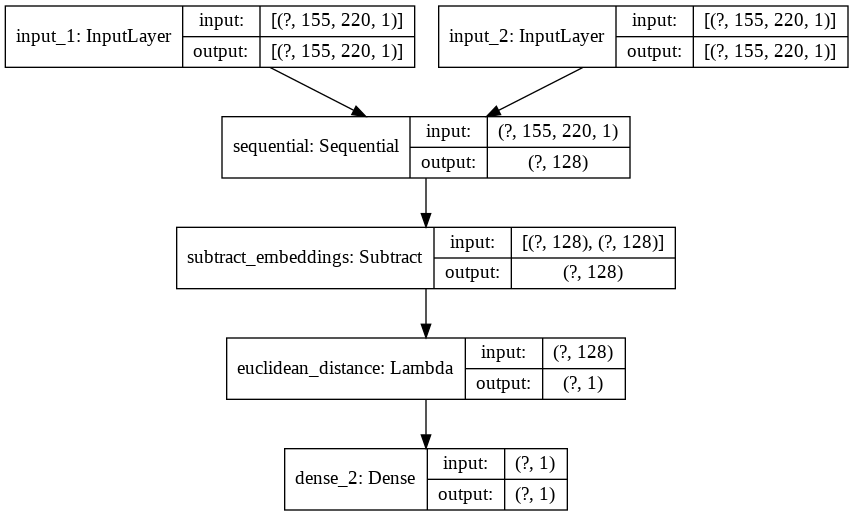

In [13]:
tf.keras.utils.plot_model(siamese_model, show_shapes=True)

# Training

## Helping Training Functions Definitions

In [14]:
# Parallelizable Function "Fetch images"
def load_processed_image(pid, images_to_fetch, signers_list, image_list, label_list, lock_signers_list, lock_batch):
  #print("Process #", pid, "has to fetch: ", images_to_fetch, "images")
  for i in range(images_to_fetch):

    # Fetch 16 images, stop when there is none left
    lock_signers_list.acquire()
    #print("Actual len of signers_list: ", len(signers_list))
    if len(signers_list) == 0:
      lock_signers_list.release()
      break
    img_pair = signers_list.pop(0)
    lock_signers_list.release()

    # Extracting the signer, the image pairs and the label
    signer = img_pair[0]
    img1 = img_pair[1][0]
    img2 = img_pair[1][1]
    label = img_pair[2]

    if label == 1:
      # If the label is marked as Genuine (1), then load both images from the Original processed folder

      path1 = routeOriginalProcessed + str(signer) + '/original_' + str(signer) + '_' + str(img1) + '_proc.png'
      path2 = routeOriginalProcessed + str(signer) + '/original_' + str(signer) + '_' + str(img2) + '_proc.png'
      #print("Path Img1:", path1)
      #print("Path Img2:", path2)
      
    else:
      # If the label is marked as Forged (0), then load images from their respective processed folder

      path1 = routeOriginalProcessed + str(signer) + '/original_' + str(signer) + '_' + str(img1) + '_proc.png'
      path2 = routeForgedProcessed + str(signer) + '/forgeries_' + str(signer) + '_' + str(img2) + '_proc.png'
      

    # Fetch IMG1
    #print("Path Img1:", path1)
    #print("Path Img2:", path2)
    img1 = image.load_img(path1, target_size = (155, 200), color_mode="grayscale")
    img1 = image.img_to_array(img1)

    # Fetch IMG2
    img2 = image.load_img(path2, target_size = (155, 200), color_mode="grayscale")
    img2 = image.img_to_array(img2)

    # Add Image pair to the Image list and label to the Label List
    lock_batch.acquire()
    image_list += [[img1, img2]]
    label_list += [int(label)]
    lock_batch.release()

# This functions allows to fetch images in parallel to training the model.
# This function is paralellized to decrease time.

def SignatureGenerator(signers_pool, isTesting, batch, number_fetch_threads):
  copy_signers = Manager().list(signers_pool.copy())
  while True:
    #print("Loading Batch Number:", k)

    # Creating N threads to fetch the 128 images
    processes = []
    img_pairs = Manager().list()
    labels = Manager().list()
    lock_batch = Lock()
    lock_signers = Lock()

    # Create the N threads
    for i in range(number_fetch_threads):
      p = Process(target=load_processed_image, args=[i, (batch//number_fetch_threads), copy_signers, img_pairs, labels, lock_signers, lock_batch])
      p.start()
      processes.append(p)

    for process in processes:
      process.join()
    
    # Casting to List
    img_pairs = list(img_pairs)
    labels = list(labels)

    # Casting to Numpy Arrays
    img_pairs = [np.array(img_pairs)[:,0], np.array(img_pairs)[:,1]]
    labels = np.array(labels)
    
    if len(copy_signers) == 0:
      copy_signers = Manager().list(signers_pool.copy())

    if isTesting:
      yield(img_pairs)
    else:
      yield(img_pairs, labels)



## Callbacks

In [15]:
#pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [16]:
def make_callbacks(count, date):
  # Checkpoint callback - Save best model
  dir_path = "/content/drive/My Drive/SP2/SiameseNN/"
  model_path = dir_path + 'Models/' + date + '/' + str(count) + '/cp.ckpt'
  filepath = model_path # + 'best' + str(count) + '.hdf5'
  checkpoint_callback = ModelCheckpoint(
      filepath,
      verbose=1,
      save_weights_only=True, 
      save_best_only = True,
      save_freq='epoch'
  )

  # Tensorboard callback
  logDir = dir_path + 'Logs/' + date + '/' + str(count) + '/'
  tsboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=1)
  estopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True, min_delta = 0.01)
  
  return [checkpoint_callback, tsboard_callback, estopping_callback]

## Model Training

In [17]:
# Useful Variables to Track progress
tryForToday = 3
#tryForToday += 1
today = str(date.today())
print(today)

2020-09-17


In [18]:
batch_size = 128
epochs = 200
samples_per_train = len(train_signers)//batch_size  + (1 if ((len(train_signers)%batch_size) > 0) else 0) 
samples_per_validation = len(validation_signers)//batch_size + (1 if ((len(validation_signers)%batch_size) > 0) else 0) 
number_fetch_threads = 4

callbacks_list = make_callbacks(tryForToday, today)

siamese_model.fit(
    x=SignatureGenerator(train_signers, False, batch_size, number_fetch_threads),
    steps_per_epoch=samples_per_train,
    epochs=epochs,
    validation_data=SignatureGenerator(validation_signers, False, batch_size, number_fetch_threads),
    validation_steps=samples_per_validation,
    verbose=1,
    callbacks = callbacks_list,
    )

Epoch 1/200
 1/15 [=>............................] - ETA: 0s - loss: 1.4615WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 3/15 [=====>........................] - ETA: 2:29 - loss: 1.3808

KeyboardInterrupt: ignored

## Visualize Training Results

In [ ]:
#%tensorboard --logdir '/content/drive/My Drive/SP2/SiameseNN/Logs/' --port=8011

# Testing

## Helping Testing Functions Definitions

In [ ]:
# This functions allows to fetch images in parallel to training the model.
# This function is paralellized to decrease time.
'''
number_fetch_threads = 1
def SignatureTestGenerator(signers_pool):
  k = 0
  copy_signers = Manager().list(signers_pool.copy())
  to_fetch = len(copy_signers)
  while True:
    #print("Loading Batch Number:", k)

    # Creating N threads to fetch the 128 images
    processes = []
    img_pairs = Manager().list()
    labels = Manager().list()
    lock_batch = Lock()
    lock_signers = Lock()

    # Create the N threads
    for i in range(number_fetch_threads):
      p = Process(target=load_processed_image, args=[i, 1, copy_signers, img_pairs, labels, lock_signers, lock_batch])
      p.start()
      processes.append(p)

    for process in processes:
      process.join()
    
    # Casting to List
    img_pairs = list(img_pairs)
    labels = list(labels)

    # Casting to Numpy Arrays
    img_pairs = [np.array(img_pairs)[:,0], np.array(img_pairs)[:,1]]
    labels = np.array(labels)
    
    if k\len(copy_signers) == 0:
      copy_signers = Manager().list(signers_pool.copy())

    yield(img_pairs)
'''

In [ ]:
def compute_accuracy_roc(predictions, labels):
   '''Compute ROC accuracy with a range of thresholds on distances.
   '''
   dmax = np.max(predictions)
   dmin = np.min(predictions)
   nsame = np.sum(labels == 1)
   ndiff = np.sum(labels == 0)
   
   step = 0.01
   max_acc = 0
   
   for d in np.arange(dmin, dmax+step, step):
       idx1 = predictions.ravel() <= d
       idx2 = predictions.ravel() > d
       
       tpr = float(np.sum(labels[idx1] == 1)) / nsame       
       tnr = float(np.sum(labels[idx2] == 0)) / ndiff
       acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
       if (acc > max_acc):
           max_acc = acc
           
   return max_acc

## Loading Model (Weights)

In [ ]:
model_path = '/content/drive/My Drive/SP2/SiameseNN/Models/' + today + '/' + str(tryForToday) + '/cp.ckpt'

siamese_model.load_weights(model_path)
print (model_path)

## Evaluating Model

In [ ]:
number_of_samples = 500 if len(test_signers) > 500 else len(test_signers)
eval_pool = random.sample(test_signers, number_of_samples)

eval = siamese_model.predict(
    x=SignatureGenerator(eval_pool, True, 1, 1),
    steps = len(eval_pool),
    verbose=1
)

In [ ]:
samples_per_test = (len(eval_pool)//batch_size) + (1 if ((len(eval_pool)%batch_size) > 0) else 0) 

siamese_model.evaluate(
    x=SignatureGenerator(eval_pool, False, batch_size, number_fetch_threads),
    steps= samples_per_test,
    verbose= 1,
)

# Results

## Helping Results Functions Definitions

In [ ]:
# Build Confusion matrix
import seaborn as sns

def show_confussion_matrix(correct, predictions, labels, fig_size):
  conf_matrix = tf.math.confusion_matrix(labels=correct, predictions=predictions)

  figure = plt.figure(figsize=fig_size)
  sns.heatmap(
      conf_matrix,
      annot=True,
      cmap=plt.cm.Blues,
      xticklabels=labels,
      yticklabels=labels
      )

  plt.tight_layout()
  plt.ylabel('True Case')
  plt.xlabel('Predicted Case')

  plt.show()

## Confusion Matrix

In [ ]:
# Getting correct labels
correct = list(map(lambda x: x[2], eval_pool))

# Getting predictions
threshold = sum(eval) / len(eval)
threshold
predictions = list(map(lambda x: 0 if x > threshold else 1, eval))

# Labels
labels = ["Forged", "Genuine"]

# Confusion Matrix
show_confussion_matrix(correct, predictions, labels, (5,5))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(correct, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(correct, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(correct, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(correct, predictions)
print('F1 score: %f' % f1)